# 简单的时间序列预测

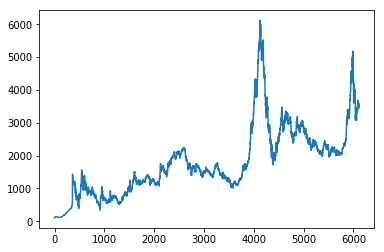

W0118 15:55:52.603152 140647560476480 deprecation.py:323] From <ipython-input-1-3a687dee07e9>:55: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0118 15:55:52.605602 140647560476480 deprecation.py:323] From <ipython-input-1-3a687dee07e9>:55: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W0118 15:55:52.649688 140647560476480 deprecation.py:323] From <ipython-input-1-3a687dee07e9>:57: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W011

Number of iterations: 0  loss: 3.2206345
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.6890087
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.6899295
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.061622437
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.020376392
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.02245471
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.073109485
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 2.6177356
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.18738717
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.042162433
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.7560502
model_save model_save1/modle.ckpt
The train has finished


W0118 15:55:59.689927 140647560476480 deprecation.py:323] From /home/liyuan3970/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


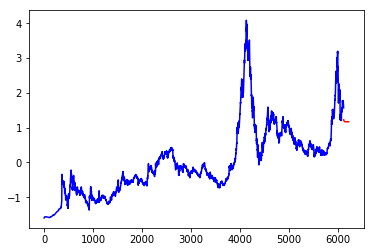

In [1]:
#coding=utf-8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
f=open('dataset_1.csv')  
df=pd.read_csv(f)     
data=np.array(df['max'])
data=data[::-1]  
print(data)
#plt.figure()
#plt.plot(data)
#plt.show()
normalize_data=(data-np.mean(data))/np.std(data)
#相当于将数据进行转置
normalize_data=normalize_data[:,np.newaxis] 
#print(normalize_data)
#print(len(data),len(normalize_data))

time_step=20   #实际上就是数据的周期   
rnn_unit=10      
lstm_layers=2
batch_size=60     
input_size=1      
output_size=1     
lr=0.0006       

#　输入数据和输出数据
train_x,train_y=[],[] 
print(len(normalize_data)-time_step-1)
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]
    y=normalize_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist())#(6000,20)个数据
 
X=tf.placeholder(tf.float32, [None,time_step,input_size])    
Y=tf.placeholder(tf.float32, [None,time_step,output_size]) 
print(X.shape)


weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }


def lstm(batch):      
    w_in=weights['in']
    print('w:',w_in.shape)
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])
    print('input:',input.shape)  
    input_rnn=tf.matmul(input,w_in)+b_in
    print('input_rnn:',input_rnn.shape)
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  
    print('input_rnn:',input_rnn.shape) 
    cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicLSTMCell(rnn_unit) for i in range(lstm_layers)])
    init_state=cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    print('output_rnn:',output_rnn.shape)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    print('output_rnn:',output_rnn.shape)
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    print('pred:',pred.shape)
    print('final_states:',final_states)
    return pred,final_states


def train_lstm():
    global batch_size
    with tf.variable_scope("sec_lstm"):
        pred,_=lstm(batch_size)
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #这是训练次数
        for i in range(1000): #We can increase the number of iterations to gain better result.
            step=0
            start=0
            end=start+batch_size
            while(end<len(train_x)):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                start+=batch_size
                end=start+batch_size
                
                if step%10==0:
                    print("Number of iterations:",i," loss:",loss_)
                    print("model_save",saver.save(sess,'model_save1/modle.ckpt'))
                    #I run the code in windows 10,so use  'model_save1\\modle.ckpt'
                    #if you run it in Linux,please use  'model_save1/modle.ckpt'
                step+=1
        print("The train has finished")
train_lstm()

def prediction():
    with tf.variable_scope("sec_lstm",reuse=tf.AUTO_REUSE):
        pred,_=lstm(1)    
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        saver.restore(sess, 'model_save1/modle.ckpt') 
        #I run the code in windows 10,so use  'model_save1\\modle.ckpt'
        #if you run it in Linux,please use  'model_save1/modle.ckpt'
        prev_seq=train_x[-1]
        predict=[]
        #预测的数目
        for i in range(1000):
            next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
            predict.append(next_seq[-1])
            prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
        
        plt.figure()
        plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
        plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')
        plt.show()

prediction() 

# 多特征的时间序列的预测

W0118 16:16:23.467331 140309230208832 deprecation.py:323] From <ipython-input-1-59227c5c9180>:70: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0118 16:16:23.554098 140309230208832 deprecation.py:323] From <ipython-input-1-59227c5c9180>:84: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W0118 16:16:23.598182 140309230208832 deprecation.py:323] From <ipython-input-1-59227c5c9180>:86: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W011

Number of iterations: 0  loss: 0.20271032
Number of iterations: 1  loss: 0.10271537
Number of iterations: 2  loss: 0.05582974
Number of iterations: 3  loss: 0.033114206
Number of iterations: 4  loss: 0.029014366
Number of iterations: 5  loss: 0.02684789
Number of iterations: 6  loss: 0.022792587
Number of iterations: 7  loss: 0.016206866
Number of iterations: 8  loss: 0.010013011
Number of iterations: 9  loss: 0.0066433777
The train has finished


W0118 16:16:37.469297 140309230208832 deprecation.py:323] From /home/liyuan3970/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


The accuracy of this predict: 0.06055768362560703


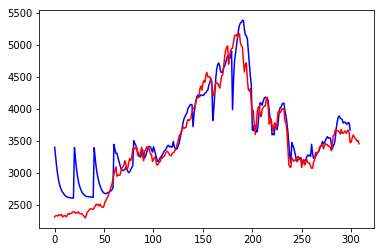

In [1]:
#coding=utf-8

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

rnn_unit=10         #隐层神经元的个数
lstm_layers=2       #隐层层数
input_size=7
output_size=1
lr=0.0006         #学习率
#——————————————————导入数据——————————————————————
f=open('src/dataset_2.csv')
df=pd.read_csv(f)     #读入股票数据
data=df.iloc[:,2:10].values  #取第3-10列


#获取训练集
def get_train_data(batch_size=60,time_step=20,train_begin=0,train_end=5800):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  #标准化
    train_x,train_y=[],[]   #训练集
    for i in range(len(normalized_train_data)-time_step):
       if i % batch_size==0:
           batch_index.append(i)
       x=normalized_train_data[i:i+time_step,:7]
       y=normalized_train_data[i:i+time_step,7,np.newaxis]
       train_x.append(x.tolist())
       train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y


#获取测试集
def get_test_data(time_step=20,test_begin=5800):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  #标准化
    size=(len(normalized_test_data)+time_step-1)//time_step  #有size个sample
    test_x,test_y=[],[]
    for i in range(size-1):
       x=normalized_test_data[i*time_step:(i+1)*time_step,:7]
       y=normalized_test_data[i*time_step:(i+1)*time_step,7]
       test_x.append(x.tolist())
       test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:7]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,7]).tolist())
    return mean,std,test_x,test_y


#——————————————————定义神经网络变量——————————————————
#输入层、输出层权重、偏置、dropout参数

weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }
keep_prob = tf.placeholder(tf.float32, name='keep_prob')    
#——————————————————定义神经网络变量——————————————————
def lstmCell():
    #basicLstm单元
    basicLstm = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    # dropout
    drop = tf.nn.rnn_cell.DropoutWrapper(basicLstm, output_keep_prob=keep_prob)
    return basicLstm

def lstm(X):
    
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell = tf.nn.rnn_cell.MultiRNNCell([lstmCell() for i in range(lstm_layers)])
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

#————————————————训练模型————————————————————

def train_lstm(batch_size=60,time_step=20,train_begin=2000,train_end=5800):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step,train_begin,train_end)
    with tf.variable_scope("sec_lstm"):
        pred,_=lstm(X)
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(10):     #这个迭代次数，可以更改，越大预测效果会更好，但需要更长时间
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]],keep_prob:0.5})
            print("Number of iterations:",i," loss:",loss_)
        saver.save(sess,'model_save2/modle.ckpt')
        #I run the code on windows 10,so use  'model_save2\\modle.ckpt'
        #if you run it on Linux,please use  'model_save2/modle.ckpt'
        print("The train has finished")
train_lstm()

#————————————————预测模型————————————————————
def prediction(time_step=20):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    with tf.variable_scope("sec_lstm",reuse=tf.AUTO_REUSE):
        pred,_=lstm(X)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #参数恢复
        module_file = tf.train.latest_checkpoint('model_save2')
        saver.restore(sess, module_file)
        test_predict=[]
        for step in range(len(test_x)-1):
          prob=sess.run(pred,feed_dict={X:[test_x[step]],keep_prob:1})
          predict=prob.reshape((-1))
          test_predict.extend(predict)
        test_y=np.array(test_y)*std[7]+mean[7]
        test_predict=np.array(test_predict)*std[7]+mean[7]
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])  #偏差程度
        print("The accuracy of this predict:",acc)
        #以折线图表示结果
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='b',)
        plt.plot(list(range(len(test_y))), test_y,  color='r')
        plt.show()

prediction()
